In [ ]:
!pip install transformers
!pip install torch
!pip install bertopic
!pip install openai
!pip install pinecone-client

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertTokenizer, BertModel
import pinecone
import torch

#BERTopic

In [8]:
#user id represented by collection of content he has accessed in the past
combined = pd.read_csv("/content/combined.csv")

In [15]:
combined.head

<bound method NDFrame.head of       Unnamed: 0  userId                                              title  \
0              0    U100  Bob Kingsley, Country Radio Legend, Dead at 80...   
1              1   U1000  Today in History: November 14 L.A.'s $1 billio...   
2              2  U10001  JuJu Smith-Schuster: Jalen Ramsey's right, I'm...   
3              3  U10003  Halle Berry Shares Photo of 6-Pack Abs on Inst...   
4              4  U10008  Jason Momoa says his marriage to Lisa Bonet pr...   
...          ...     ...                                                ...   
9995        9995  U26894  Meghan McCain confronts Trump Jr.: 'You and yo...   
9996        9996  U26898  Survivor Contestant Accused of 'Inappropriate ...   
9997        9997    U269  Snow crab sells for record price in Japan The ...   
9998        9998  U26900  Broadway Actress Laurel Griggs Dies at Age 13 ...   
9999        9999  U26901  Mitch McConnell snubbed by Elijah Cummings' pa...   

                     

In [16]:
from bertopic import BERTopic
from bertopic.representation import OpenAI
import os
import openai
# Fine-tune topic representations with GPT


In [17]:
openai.api_key = "sk-"

In [27]:
text = combined.title.tolist()
text = text[:500]

In [28]:
#representation_model = KeyBERTInspired()
representation_model = OpenAI(model="gpt-3.5-turbo-0613", chat=True)
topic_model = BERTopic(representation_model=representation_model)
topics, _ = topic_model.fit_transform(text)

In [29]:
topic_info = topic_model.get_topic_info()
print(f"topic_info {topic_info}")

topic_info     Topic  Count                                               Name  \
0      -1    219  -1_Various news articles and events related to...   
1       0     32  0_Controversies and crimes involving missing p...   
2       1     26  1_Wheel of Fortune guest delivers hilarious of...   
3       2     25  2_Broadway Actress Laurel Griggs dies at age 1...   
4       3     24  3_Royal Family's Birthday Celebration and Chri...   
5       4     20  4_Charles Rogers, former Michigan State footba...   
6       5     20                5_Celebrity news and trends in 2019   
7       6     19  6_Miguel Cervantes' Wife Reveals Daughter's De...   
8       7     18             7_NFL reacts to Packers win over Lions   
9       8     16  8_Black Friday Deals, Retirement, Great White ...   
10      9     15  9_NFL player Justin Bannan arrested for attemp...   
11     10     12  10_Bob Kingsley, Country Radio Legend, Dead at 80   
12     11     11  11_Deaths of Marlboro Man Bob Norris, Kevin Sp..

In [20]:
topic_info[['Topic','Name','Representation','Representative_Docs']]

,Topic,Name,Representation,Representative_Docs
0,-1,"-1_Black Friday deals, Prince Harry and Meghan...","[Black Friday deals, Prince Harry and Meghan M...",[Chrisleys sue Georgia tax official with link ...
1,0,"0_Charles Rogers, former Michigan State footba...","[Charles Rogers, former Michigan State footbal...",[The 1 reason you shouldn't hesitate to claim ...
2,1,1_Celebrities and Personal Tragedies,[Celebrities and Personal Tragedies],[The Giudice family reunites and more ICYMI ce...
3,2,"2_California sheriff's deputy shot dead, ride-...","[California sheriff's deputy shot dead, ride-a...",[Jason Momoa says his marriage to Lisa Bonet p...


In [32]:
topic_info['Representative_Docs_Summary']= topic_info.apply(lambda row: ', '.join([str(sublist) for sublist in row['Representative_Docs']]), axis=1)
for index, row  in topic_info.iterrows():
  print({row['Topic']},":\n", {row['Name']}," :\n ", row['Representation'])
  #summary = " . ".join(row['Representative_Docs'])
  summary = row['Representative_Docs_Summary']
  print(f"{len(summary)} : {summary}")


{-1} :
 {'-1_Various news articles and events related to celebrities, holidays, sports, and social issues'}  :
  ['Various news articles and events related to celebrities, holidays, sports, and social issues']
2192 : Kiss Cancel 'End of the Road' Tour of Australia and New Zealand Due to Illness NFL world reacts to officials handing Packers win over Lions 'The face of heroin': Mom shares haunting before and after pics of addiction The Amelia Earhart Mystery Stays Down in the Deep The Last McDonald's Burger in Iceland Just Turned 10. It's Still in Perfect Condition. Family of toddler who fell from cruise ship 'utterly crushed' after grandfather charged For the first time ever, a US cheese is named best in the world Navy Submarine, Missing for 75 Years, Is Found Off Okinawa 'Priceless' finds that turned out to be worthless Goats Munching on Vegetation Helped Save the Reagan Presidential Library in California Wildfire, 'One in a million' deer captured on camera in Michigan woods Prince Har

In [33]:
system_prompt = """You are a data analyst looking through the summary of various news articles that users read. You read the user's message and genrates inherent topics that they are interested in.
Come up with maximum of 5 topics"""
sys_messages = [
        {"role": "system", "content": f"{system_prompt}"}]

In [35]:
for sum in topic_info['Representative_Docs_Summary']:
  messages = sys_messages.copy()
  messages.append({"role": "user", "content": sum})
  #print(messages)

  response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=messages,
        temperature=0.8,
        max_tokens=150,
        n=1,
        stop=None,
    )
  generated_topics = response.choices[0]['message']['content']
  print(generated_topics)
  print("************")

1. Music - Kiss Cancel 'End of the Road' Tour of Australia and New Zealand Due to Illness
2. Sports - NFL world reacts to officials handing Packers win over Lions
3. Addiction - 'The face of heroin': Mom shares haunting before and after pics of addiction
4. History/Mystery - The Amelia Earhart Mystery Stays Down in the Deep
5. Food - The Last McDonald's Burger in Iceland Just Turned 10. It's Still in Perfect Condition.
************
1. Legal issues and criminal cases: Chinese billionaire's son banned, Texas mom goes to prison, husband arrested for wife's murder, missing girl found with charges.

2. Personal stories and human interest: Model's surprise pregnancy, survivor's account of Mexico ambush, missing person found alive, Jayme Closs's recovery.

3. Socio-political issues: Supreme Court interruptions during DACA arguments, tensions between Prince Harry and William, ISIS bride seeking second chance.

4. Entertainment and celebrity news: Jessica Biel's old interview, Lori Loughlin's n

In [57]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def get_wordcloud_for_user(recommendations):

    stopwords = set(STOPWORDS).union([np.nan, 'NaN', 'S'])

    wordcloud = WordCloud(
                   max_words=50000,
                   min_font_size =12,
                   max_font_size=50,
                   relative_scaling = 0.9,
                   stopwords=set(STOPWORDS),
                   normalize_plurals= True
    )
    print(recommendations)
    clean_titles = [word for word in recommendations if word not in stopwords]
    clean_titles = [word for line in generated_topics.split("\n") for word in line.split()]
    title_wordcloud = wordcloud.generate(' '.join(clean_titles))

    plt.imshow(title_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

1. Wildlife: 'One in a million' deer captured on camera in Michigan woods
2. Sports: NFL, Olympics, soccer star Alex Morgan, swimmer Ryan Lochte
3. Current events: Buckingham Palace tradition, Joe Biden denied Communion, Niagara Falls incident, Browns cutting WR Antonio Callaway
4. Entertainment: Kiss tour cancellation, country music scandals, Hannah Brown surrounded by exes
5. Technology/Energy: Solar power storage breakthrough, tech billionaire's mansion price cut


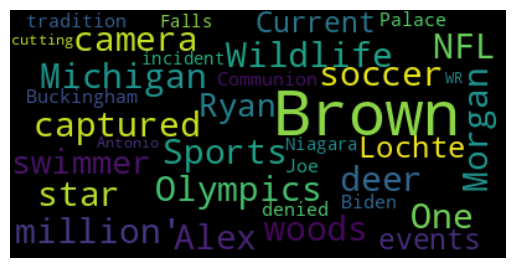

In [58]:
get_wordcloud_for_user(generated_topics)